# IMA204 Practical Session - Segmentation of medical images



# Introduction

Images to use are provided in a zip file called **data.zip** to install in your local directory from where you are running this notebook.

The goal of this practical session is to push K-means segmentation method as a pre-segmentation tool on different types of medical images: CT scans for the segmentation of kidneys and tumors, MRI for the corpus callosum in the brain , temporal sequences of MRI images for segmentation of the myocardium.

You are provided with pre-processing ideas.
You will have to adjust a pipeline for **AT LEAST** one application (kidney/tumor, corpus callosum or heart).

You have to submit your code and comment your results.

**Deadline**: You will have to upload a single jupyter notebook .ipynb with your answers (code + text) before the deadline (please check on Ecampus/Moodle).

**The uploaded file should be named 'TP_SegMedImage_YOURSURNAME.ipynb'.**

**RUN THE WHOLE NOTEBOOK FIRST TO GET A FULL OVERVIEW OF USE-CASES AND THE NOTION OF HYPERPARAMETERS.**

In [310]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For listing files in local foler
import glob

# For loading .mat files
from scipy.io import loadmat

import skimage
from skimage.io import imread
from skimage import morphology
from skimage.segmentation import watershed
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from scipy import ndimage
from skimage.measure import find_contours
import skimage.morphology as morpho
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage.filters import gaussian

# For Kmeans
import cv2

Working_directory = os.getcwd()
print('Working_directory = ',Working_directory)


Working_directory =  /content


In [311]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [312]:
def my_kmeans(image,k):
    #k = number of clusters

    # Reshaping the image
    pixel_vals = image.reshape((-1,1))

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria   = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) #criteria
    retval, labels, centers = cv2.kmeans(pixel_vals, k,
                None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    centers = np.uint8(centers) # convert data into 8-bit values

    segmented_data   = centers[labels.flatten()] # Mapping labels to center points( RGB Value)
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape)) # reshape data into the original image dimensions

    return segmented_image,segmented_labels


def my_colormap_white_bkg(Colormap_name,numLabels):
    #numLabels = number of colors

    Colormap  = plt.get_cmap(Colormap_name, numLabels)
    newcolors = Colormap(np.linspace(0, 1, numLabels))
    bkg_color = np.array([256/256, 256/256, 256/256, 1])
    max_color = np.array([0/256, 0/256, 0/256, 1])
    newcolors[numLabels-1, :] = max_color
    newcolors[0, :] = bkg_color
    newcmp = ListedColormap(newcolors)
    return newcmp

## Abdominal CT

You have at your disposal **6 abdominal CT scans** of different subjects. Subjects may have renal tumor. You also have the manual segmentations for both kidney and, when present, the tumor.

Variables defined: <br>
* abdominalCT_path
* listImagesabdCT
* Img_abdo_ex
* Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

There are 6 abdomical CT images
Reading image  /content/drive/MyDrive/data/abdominalCT/CTs2.tiff
[  0 127 255]


Text(0.5, 1.0, 'Image +contour tumor')

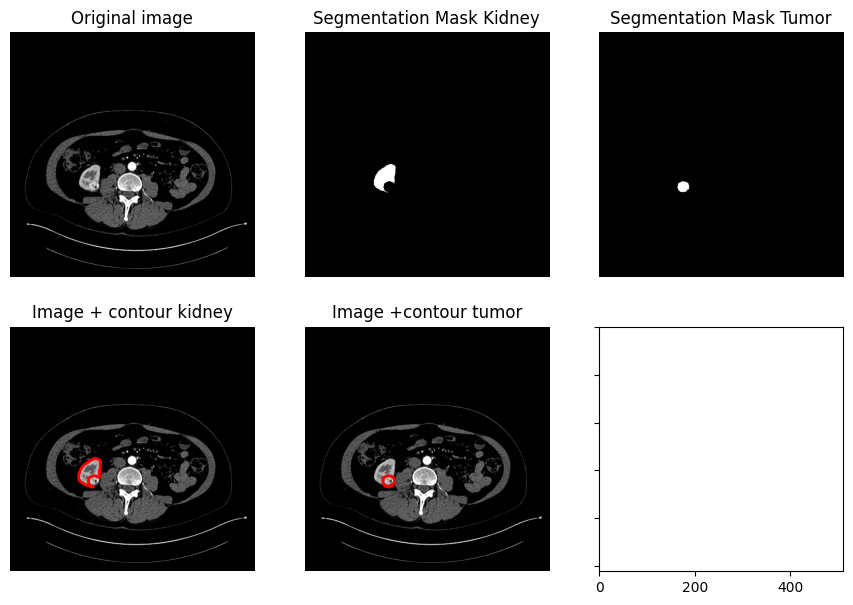

In [313]:
abdominalCT_path = Working_directory + '/drive/MyDrive/data/abdominalCT'
os.listdir(abdominalCT_path)
listImagesabdCT=glob.glob(abdominalCT_path + '/*-seg.tiff')
print('There are', len(listImagesabdCT),  'abdomical CT images')

# Choose a figure and plot it with the ground truth segmentation
indexIm=0 # between 0 and 5

# Abdominal CT
filename_Segmentation = listImagesabdCT[indexIm]
Labels_abdo_ex   = imread(filename_Segmentation)
filename         = filename_Segmentation[:-9] + '.tiff'
Img_abdo_ex      = imread(filename)

print('Reading image ', filename)
print(np.unique(Labels_abdo_ex))

if Img_abdo_ex.shape != Labels_abdo_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')

# In Labels_abdo_ex we may have two values: 127 is for kidney and 255 for renal tumor
Seg_abdo_kidney_ex=Labels_abdo_ex==127
if np.sum(Seg_abdo_kidney_ex)==0:
  print('There is no kidney')
Cont_abdo_kidney_ex = find_contours(Seg_abdo_kidney_ex, 0.5)

Seg_abdo_tumor_ex=Labels_abdo_ex==255
if np.sum(Seg_abdo_tumor_ex)==0:
  print('There is no tumor')
Cont_abdo_tumor_ex = find_contours(Seg_abdo_tumor_ex, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_abdo_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(Seg_abdo_kidney_ex,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask Kidney")
grid[2].imshow(Seg_abdo_tumor_ex,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Segmentation Mask Tumor")
grid[3].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_kidney_ex:
  grid[3].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[3].axis('off')
grid[3].set_title("Image + contour kidney")
grid[4].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_tumor_ex:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[4].axis('off')
grid[4].set_title("Image +contour tumor")


# Brain MRI

Here you can select medial slices of the brain of **4 different subjects**. You also have manual segmentations of the corpus callosum.

Variables defined: <br>
* brainMRI_path
* listImagesbrainMRI
* Seg_brain_ex
* Img_brain_ex

There are 4 brain MRI images
['/content/drive/MyDrive/data/brainMRI/MRIs4-seg.png', '/content/drive/MyDrive/data/brainMRI/MRIs3-seg.png', '/content/drive/MyDrive/data/brainMRI/MRIs2-seg.png', '/content/drive/MyDrive/data/brainMRI/MRIs1-seg.png']
Reading image  /content/drive/MyDrive/data/brainMRI/MRIs1.png


Text(0.5, 1.0, 'Image with segmentation\n corpus callosum')

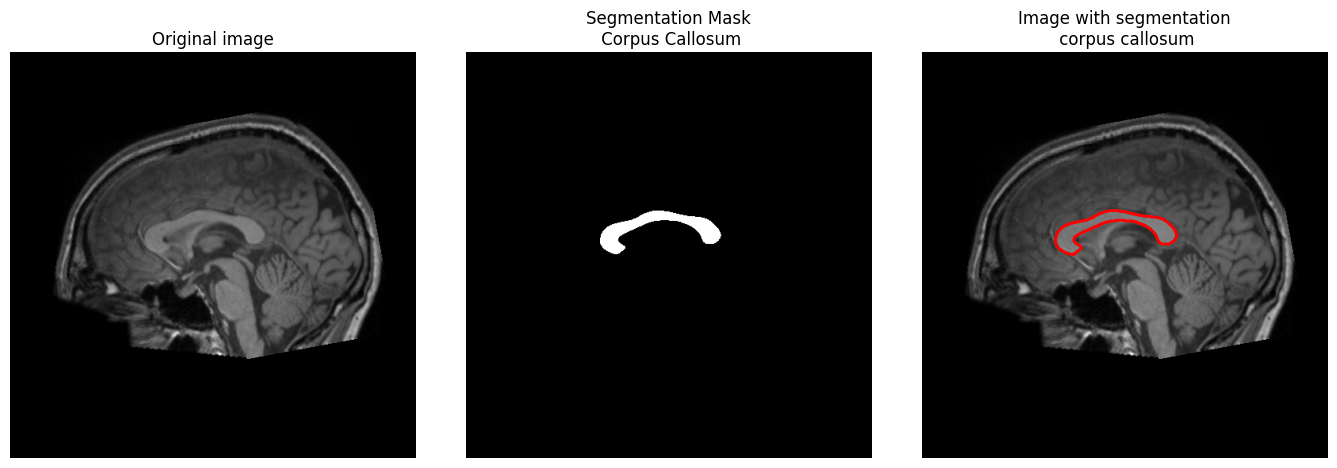

In [314]:
brainMRI_path = Working_directory + '/drive/MyDrive/data/brainMRI'
os.listdir(brainMRI_path)
listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

# Choose a brain MRI and plot it with the ground truth segmentation
indexIm      = 3 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename)

print('Reading image ', filename)

if Img_brain_ex.shape != Seg_brain_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')

# In Im Seg we have masks of the corpus callosum
maskCC      = Seg_brain_ex==255
contourMask = find_contours(maskCC, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_brain_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskCC,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask\n Corpus Callosum");
grid[2].imshow(Img_brain_ex, cmap='gray')
for contour in contourMask:
  grid[2].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[2].axis('off')
grid[2].set_title("Image with segmentation\n corpus callosum")


# Cardiac MRI

The last section is about MRI sequences of the heart.
You are provided with **a single use case**.
Your goal is to segment the left ventricule. Be careful, the segmentation is not a maks but a series of points (landmarks). To obtain a binary mask, you should first interpolate the points (using for instance a spline). <br>

The structure of this image data is more complex and needs some coding to load single slices to segment.


Variables defined: <br>
* MRIheart_path
* Img_cardiac_ex
* Seg_cardiac_ex


MRI volume of the heart composed of 11 slices along the z axis and 20 temporal frames. Each slice is an image  256  x  256
For each slice and at each time frame we have a manual segmentation composed of 65 2D landmarks
Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value: [[-99999]]


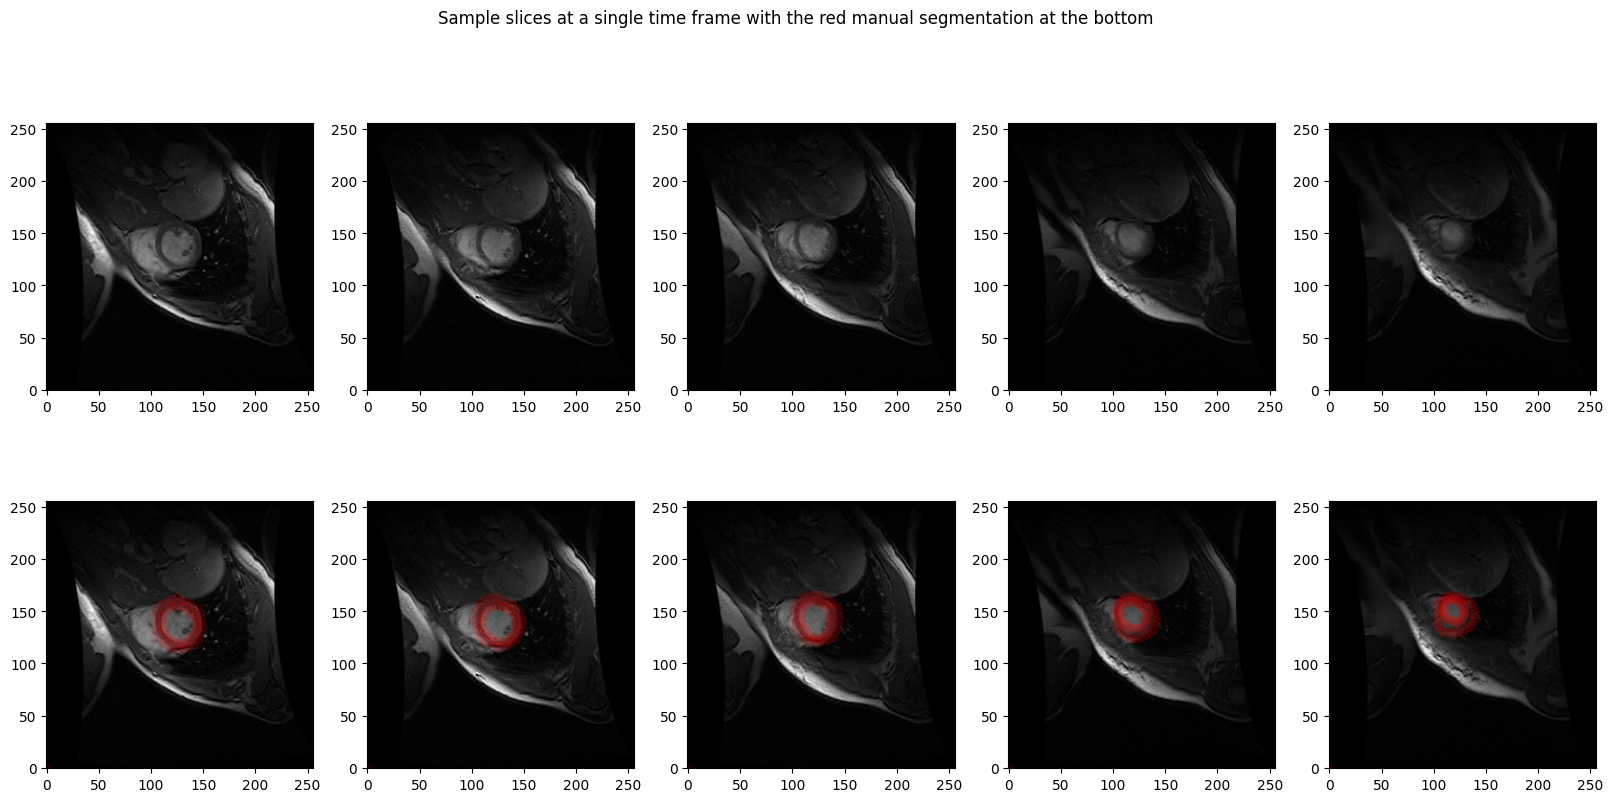

In [315]:

# Read one case
MRIheart_path = Working_directory + '/drive/MyDrive/data/MRIheart/'
os.listdir(MRIheart_path)
data          = loadmat(MRIheart_path + 'dataMRIheart.mat')
data          = data['data']
seg           = loadmat(MRIheart_path + 'segMRIheart.mat')
seg           = seg['seg']

Ex_index_select = 6
Img_cardiac_ex = data[:,:,Ex_index_select,1] # can be index 4,5,6,...
Cont_cardiac_ex = seg[Ex_index_select,1][:]

print('MRI volume of the heart composed of', data.shape[2], 'slices along the z axis and', data.shape[3],
'temporal frames. Each slice is an image ', data.shape[0], ' x ',  data.shape[1])
print('For each slice and at each time frame we have a manual segmentation composed of',seg[4,4].shape[0] , '2D landmarks')

print('Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value:', seg[0,0] )

plt.figure(figsize=(20, 9))
plt.suptitle('Sample slices at a single time frame with the red manual segmentation at the bottom')
plt.subplot(2, 5, 1)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis()

plt.subplot(2, 5, 2)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis()

plt.subplot(2, 5, 3)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis()

plt.subplot(2, 5, 4)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis()

plt.subplot(2, 5, 5)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis()

plt.subplot(2, 5, 6)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis()
plt.scatter(seg[4,1][:,0], seg[4,1][:,1], c='r',alpha=0.1)

plt.subplot(2, 5, 7)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis()
plt.scatter(seg[5,1][:,0], seg[5,1][:,1], c='r',alpha=0.1)

plt.subplot(2, 5, 8)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis()
plt.scatter(seg[6,1][:,0], seg[6,1][:,1], c='r',alpha=0.1)

plt.subplot(2, 5, 9)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis()
plt.scatter(seg[7,1][:,0], seg[7,1][:,1], c='r',alpha=0.1)

plt.subplot(2, 5, 10)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis()
plt.scatter(seg[8,1][:,0], seg[8,1][:,1], c='r',alpha=0.1);

## For cardiac MRI: how to create a binary mask from the provided contours

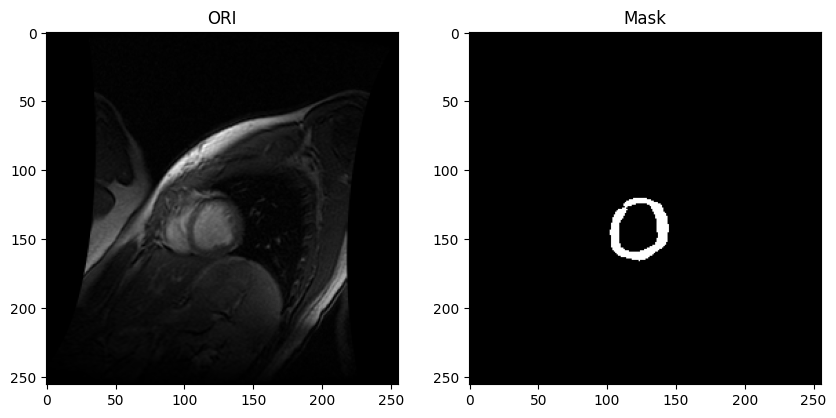

In [316]:
from skimage.draw import polygon

# Remove [0 0] point in provided contour
Cont_cardiac_ex = Cont_cardiac_ex[~np.all(Cont_cardiac_ex == 0, axis=1)]

Seg_cardiac_ex   = np.zeros_like(Img_cardiac_ex, dtype='bool')
rr, cc = polygon(Cont_cardiac_ex[:, 1], Cont_cardiac_ex[:, 0], Img_cardiac_ex.shape)
Seg_cardiac_ex[rr, cc] = 1

fig, axes        = plt.subplots(1,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_cardiac_ex,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Seg_cardiac_ex,cmap='gray')
ax[1].set_title("Mask")

plt.show()

# Preliminaries
## Mathematical Morphology

Incitations to use morphological operators seen during the previous lectures to segment the provided images.


Think about the structural elements and the hyper-parameters ... We typically adapt their values to the image resolution and type of structures targeted in our segmentation (eg. brigth or dark).



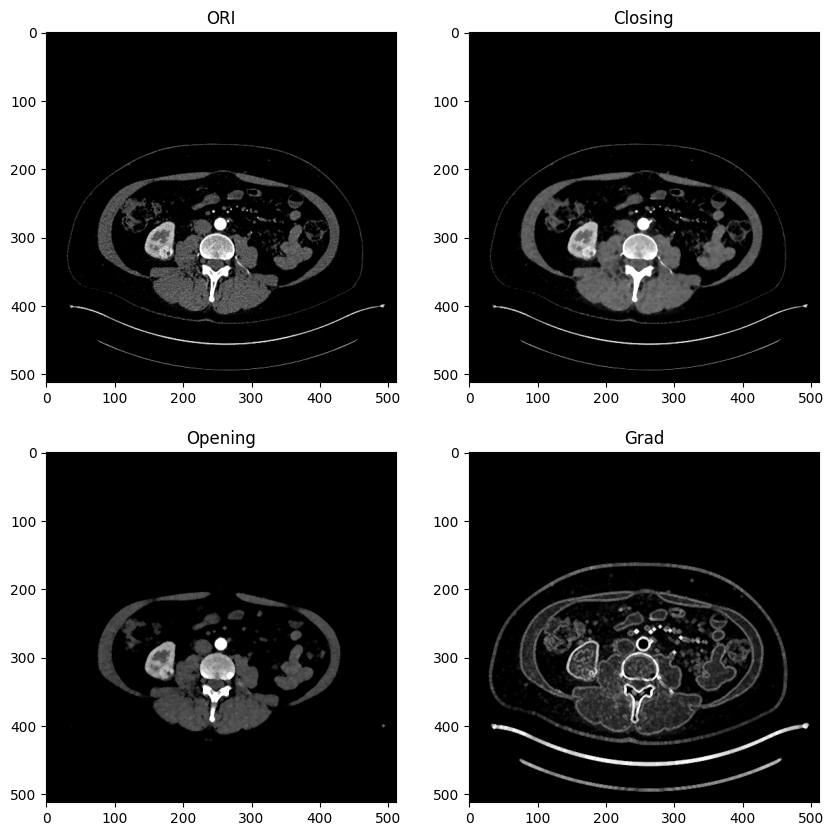

In [317]:
#Select input image
# Img_test         = Img_cardiac_ex
# Img_test         = Img_brain_ex
Img_test         = Img_abdo_ex ; # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

# Define Element
Radius           = 2
se               = disk(Radius)

# Morpho closing
Img_test_close  = morpho.closing(Img_test,se)

# Morpho Opening
Img_test_open    = morpho.opening(Img_test,se)

# Morpho Gradient
Img_test_grad  = morpho.dilation(Img_test,se)-morpho.erosion(Img_test,se)


#Figure display
fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Img_test_close,cmap='gray')
ax[1].set_title("Closing")
ax[2].imshow(Img_test_open,cmap='gray')
ax[2].set_title("Opening")
ax[3].imshow(Img_test_grad,cmap='gray')
ax[3].set_title("Grad")

plt.show()

# Preliminaries
## Regular filtering

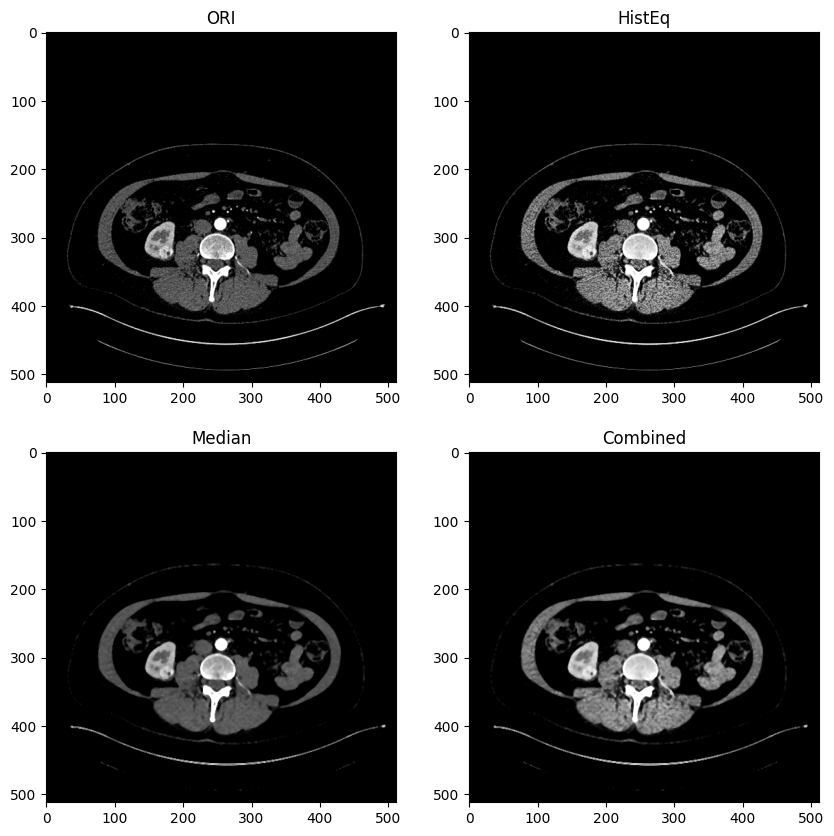

In [318]:

img_histeq    = skimage.exposure.equalize_adapthist(Img_test, clip_limit=0.03)
img_median    = ndimage.median_filter(Img_test, size=4)
img_histeqmed = ndimage.median_filter(img_histeq, size=4)

fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(img_histeq,cmap='gray')
ax[1].set_title("HistEq")
ax[2].imshow(img_median,cmap='gray')
ax[2].set_title("Median")
ax[3].imshow(img_histeqmed,cmap='gray')
ax[3].set_title("Combined");




# ASSIGNMENT:

**Question**
Develop a segmentation pipeline building upon **kmeans** as proposed below for **at least one application** and report quality of segmentation results comparing your results to the provided ground truth on multiple images.

We want you to focus on **pre-processing** your image AND **post process** your segmentation result to extract **THE structure of interest**. For the postprocessing you can rely on extraction of connected components and apply to criteria (size, shape, position,..) to extract the composant that most likely corresponds to the structure of interest.


When processing medical images, and given that you are provided with several ground-truth (gt) segmentations you can push the exercice to consider: <br>
* Cropping the field of view to remove the background (a common issue in medical images)
* Target a range of intensity values based on learning from the gt masks and corresponding images
* Learn priors on shape/intensity statistics from the provided gt masks


## Kmeans routine to segment your images
Kmeans is very often used as pre-segmentation to initialise a finer segmentation.

Provides a segmentation of the image using k-means clustering.
Be careful: Kmeans uses random initialisation and is therefore different at each run and randomly assigns  labels to clusters (0,1,2,...,K).





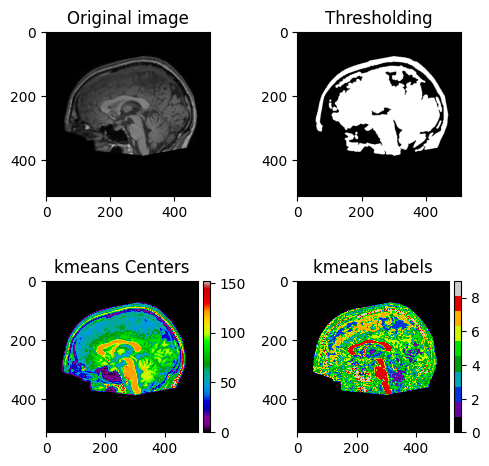

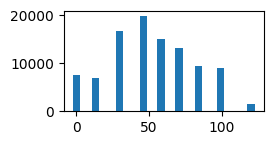

Your Target_value =  80
Distance of your Target_value to Centers =  [79 20 33  9 73 50  5 21 41 66]
Your selected label (starting with 0)=  6


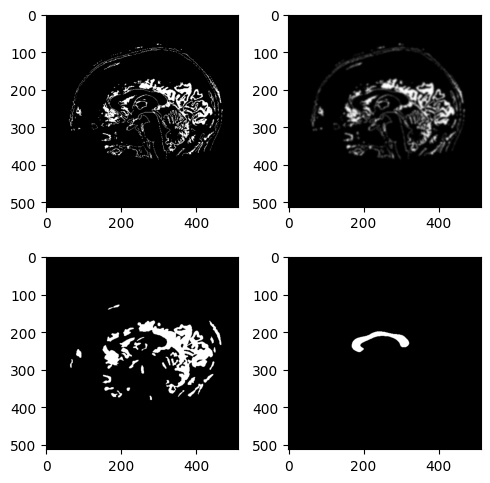

In [319]:
# Image use-case and HYPER-PARAMETER values provided as a good start

# Img_test         = Img_abdo_ex ; Img_seg_gt       = Seg_abdo_kidney_ex # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex
# nber_clusters    = 10; Target_value_thresh = 180 # For cardiac image
# Img_test            = Img_cardiac_ex; Img_seg_gt       = Seg_cardiac_ex
# nber_clusters       = 10; Target_value_thresh = 150 # For abdo image
Img_test          = Img_brain_ex ; Img_seg_gt       = Seg_brain_ex
nber_clusters     = 10; Target_value_thresh = 50 # For brain image




# [1] Example of segmentation via simple threshold
# Compute a mask thresholding above target value
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh,
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')


# [2] Example of segmentation via kmeans
Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Display results
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_thresh, cmap='gray')
ax[1].set_title('Thresholding')

tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')

tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')

fig.tight_layout()
plt.show();

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_test, Img_label_mask)
    Img_label_means[i] = tmp[0]
#print(Img_label_means)

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(),
                                         bins=Bins)
bar_width = 5
fig       = plt.figure(figsize=(2, 1))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_test, Seg_thresh)
Target_value = Target_value[0]
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
print('Your Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2,
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[3].imshow(Img_seg_gt, cmap='gray')

fig.tight_layout()
plt.show()






## From Kmeans to Connected Components

This is an example on how to exploit the results from Kmeans.
Note that this example uses several hard-coded **hyperparameters** which is not appropriate to segment robustly several cases.

If you reuse this piece of code for the question below, propose some approaches to set some of the hyperparameter values automatically (eg using the known average size of the structure of interest from the gt segmentation you have)




Max value in labels =  16
Number of connected components =  17


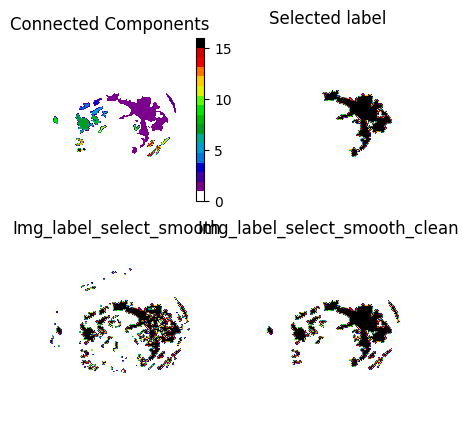

In [320]:
Img_label_select_filter = gaussian(Img_label_select, 2,
                            preserve_range=True)
Img_label_select_smooth = Img_label_select_filter>0.25
Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth, min_size=150,connectivity=1),
    area_threshold=150)

# Extract connected components
Thresh = Img_label_select_smooth_clean
output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
(numLabels, labels, stats, centroids) = output
print('Max value in labels = ',labels.max())
print('Number of connected components = ',numLabels)

# Extract 1 connected component
thresh = labels==1

# plots results
Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

tmp     = ax[0].imshow(labels, cmap=Colormap)
divider   = make_axes_locatable(ax[0])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Connected Components')
ax[0].axis('off')
fig.colorbar(tmp, cax=cax, orientation='vertical')

ax[1].imshow(thresh, cmap=Colormap)
ax[1].set_title('Selected label')
ax[1].axis('off')
ax[2].imshow(Img_label_select_smooth, cmap=Colormap)
ax[2].set_title('Img_label_select_smooth')
ax[2].axis('off')
ax[3].imshow(Img_label_select_smooth_clean, cmap=Colormap)
ax[3].set_title('Img_label_select_smooth_clean');
ax[3].axis('off');


## Implement your full segmentation pipeline

### TO DO:
* Implement a full pipeline to segment TWO EXAMPLES from a single use case. Your code must run over the two cases in a loop. We need to be able to run the code without any adjustment to local path to access the input data. <br>
* Implement and compute a quality metric (eg Dice, overlap, relative area differences, errors between max diameters (something used to measure tumors), distances between contours) that compares your final segmentation with the ground-truth.
* Extra point if you provide results on more use-cases or more than 2 examples per use case. <br>
* Feel free to also test your segmentation pipeline on images degraded by noise for example. <br>
* Your final solution can involve registration or active contours from previous lectures. Just make sure to include the required functions and imports in your final notebook.<br>

### If you use the cardiac MRI dataset:
* Extra point because extra difficulties to load and prepare the data. <br>
* In this case the data preparation is part of your code below as you can only rely on the input data provided as it is.  <br>
* Use any slice from any case you want as your "learning" ground truths on which you can learn object size or shape characteristics for example. <br>
* Test your segmentation on any slice from any case, as long as the slices were not part of your "learning" ground-truth. <br>
* See if you can get your solution to not detect anything on slices that don't contain the left ventricle myocardium. <br>


### Important instructions:
* You cannot use the ground truth of the images you segment to segment them! But you can use the ground-truths of other examples of the same use-case to learn a priori knowledge such as size or average pixel intensity.<br>
* List all your hard-coded hyperparameters at the beginning of your code, indicating a variable name and its value. You will be penalised if you leave any hard-coded hyperparameter values inside your code. <br>

Nb: Dice = np.sum([seg==gt])*2.0/(np.sum(seg)+np.sum(gt)) #seg is the segmentation and gt is the ground truth. Both are of same size

### Objective:
Our goal is to analyze specific parts of an image that we're interested in. We do this by looking at two examples from the same scenario. We'll also check how well our analysis matches up with a known, accurate example (ground truth).

### Steps:

1. **Identifying the Area of Interest**: We start by picking out the parts we're interested in from an image that's already been prepared for analysis. Think of it like finding a specific object in a picture.

2. **Measuring Key Features**: We measure several important aspects of these parts:
   - **Area**: How big is the part?
   - **Perimeter**: How long is the boundary of this part?
   - **Center Point (Centroid) Coordinates**: Where is the central point of this part located in the image?
   - **Convexity**: This is a bit technical. It's a measure that tells us how much the shape of our part of interest deviates from a perfectly smooth, outward-curved shape. A value less than or equal to 1 is expected.

3. **Assumptions for Analysis**: We assume that both the reference image (our model for comparison) and the test image (the one we are analyzing) are of the same size. This means we focus on the exact location of the center points in the images, rather than their position relative to the image size.

4. **Quality Check**: After analyzing these aspects, we compare our findings with the known, accurate example (ground truth). This helps us understand the accuracy and quality of our analysis.



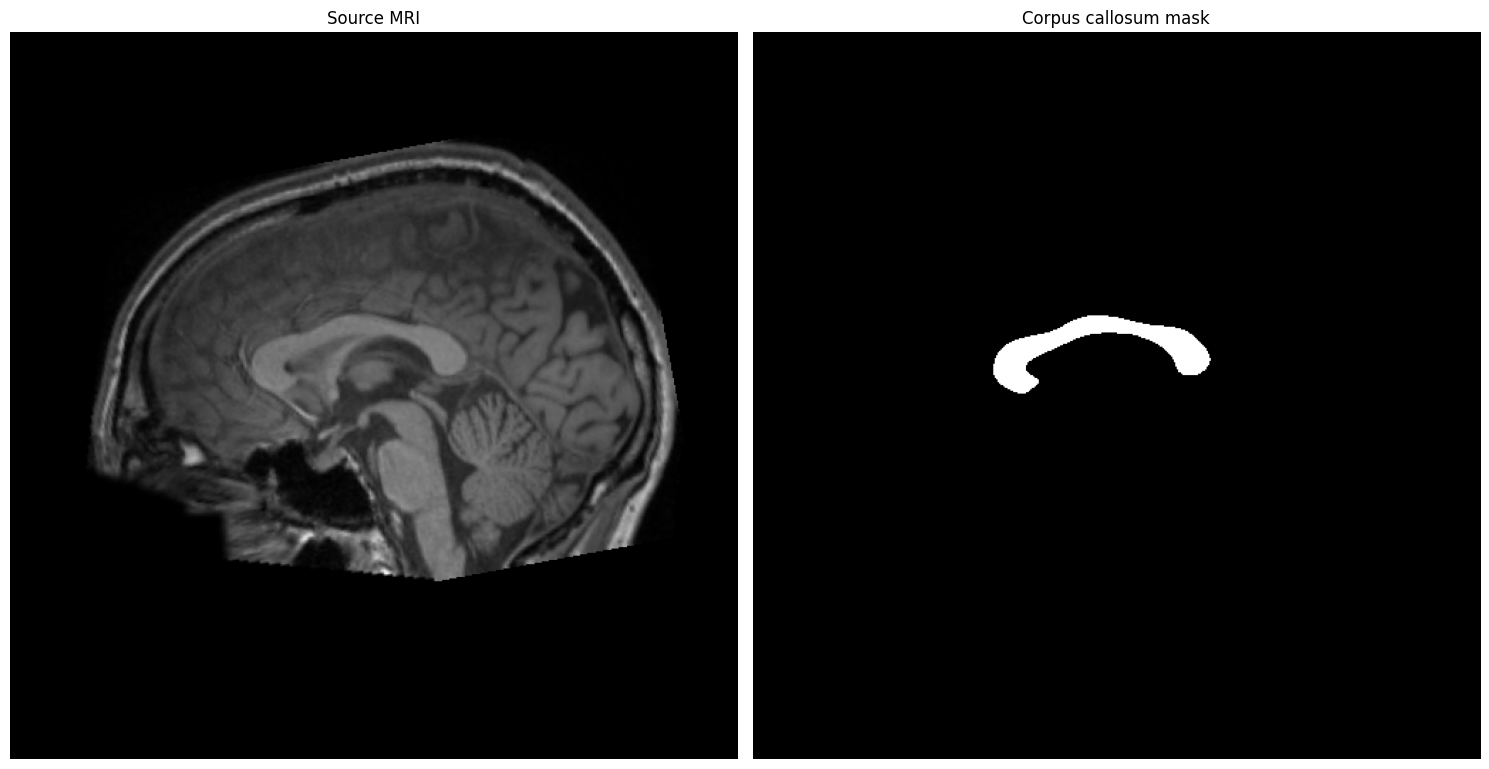

In [321]:
indexIm_ref = 3
filename_seg = listImagesbrainMRI[indexIm_ref]
Seg_brain_ref = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ref = imread(filename)

fig, ax = plt.subplots(1, 2, figsize=(15, 9))
ax[0].imshow(Img_brain_ref, cmap='gray')
ax[0].set_title('Source MRI')
ax[0].axis('off')
ax[1].imshow(Seg_brain_ref, cmap='gray')
ax[1].set_title('Corpus callosum mask')
ax[1].axis('off')

fig.tight_layout()
plt.show()

### Selection of Reference Image

For our analysis, we have selected the corpus callosum from the fourth MRI (index 3) as the reference point. This selection will aid in identifying the corpus callosum in other MRI scans. Following this choice, we will proceed to extract the previously mentioned features.


In [322]:
import numpy as np
from skimage.measure import find_contours
from skimage.morphology import convex_hull_image
from collections import deque

def components_to_images(im, comp):
    """
        Converts a list of components generated by extract_components into images
    """
    # plt.imshow(comp[1], cmap='gray')
    res_img = [np.zeros(im.shape) for i in range(len(comp))]

    for i in range(len(comp)):
        for j in range(len(comp[i])):
            x, y = comp[i][j]

            res_img[i][x][y] = 1

    return res_img


def get_components(binary_image):
    n_rows, n_cols = binary_image.shape
    visited = np.zeros_like(binary_image, dtype=bool)
    components = []

    for row in range(n_rows):
        for col in range(n_cols):
            if binary_image[row, col] == 1 and not visited[row, col]:
                component = []
                queue = deque([(row, col)])
                visited[row, col] = True
                while queue:
                    r, c = queue.popleft()
                    component.append((r, c))
                    for dr, dc in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                        r_, c_ = r+dr, c+dc
                        if (0 <= r_ < n_rows) and (0 <= c_ < n_cols) and binary_image[r_, c_] == 1 and not visited[r_, c_]:
                            queue.append((r_, c_))
                            visited[r_, c_] = True
                components.append(component)
    return components


def get_area(binary_image):
    return np.count_nonzero(binary_image)


def get_perimeter(binary_image):
    contour = find_contours(binary_image.clip(max=1))[0]
    return len(contour)


def get_centroid(binary_image):
    coords = np.argwhere(binary_image.clip(max=1) == 1)
    x_mean, y_mean = np.mean(coords, axis=0).astype(int)
    res = []
    return x_mean, y_mean


# Convexity is defined as the ratio : P(convex_hull)/P(comp)
def get_convexity(binary_image):
    comp_perimeter = get_perimeter(binary_image)
    comp_convex_hull = convex_hull_image(binary_image)
    convex_hull_perimeter  = get_perimeter(comp_convex_hull)
    return convex_hull_perimeter / comp_perimeter

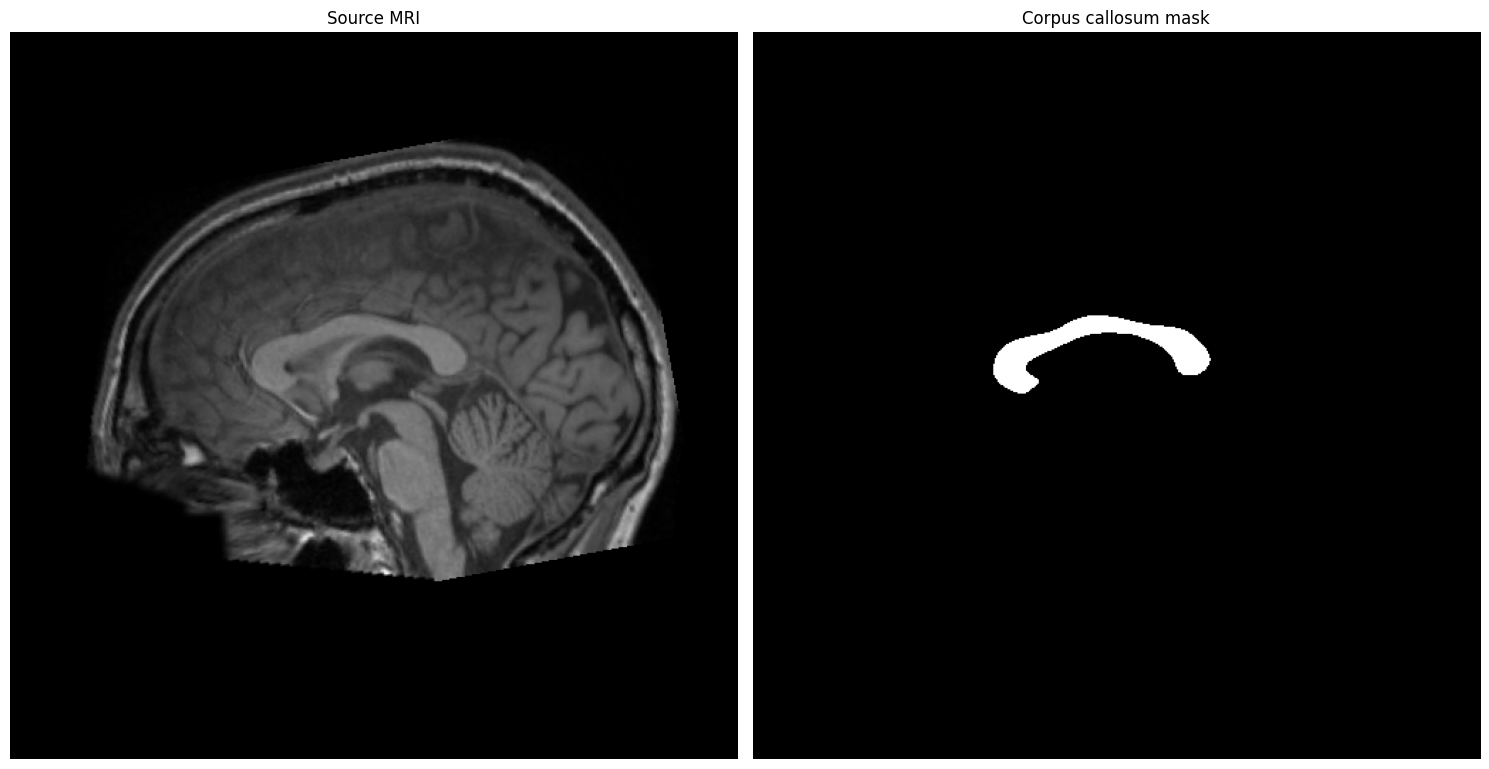

In [323]:
indexIm_ref      = 3
filename_seg = listImagesbrainMRI[indexIm_ref]
Seg_brain_ref = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ref = imread(filename)

fig, ax = plt.subplots(1, 2, figsize=(15, 9))
ax[0].imshow(Img_brain_ref, cmap='gray')
ax[0].set_title('Source MRI')
ax[0].axis('off')
ax[1].imshow(Seg_brain_ref, cmap='gray')
ax[1].set_title('Corpus callosum mask')
ax[1].axis('off')

fig.tight_layout()
plt.show()

### Processing

Next, we will apply these descriptors to analyze another brain MRI. This step involves utilizing the previously determined features to examine and compare with a new MRI scan.

In [324]:
ref_centroid = get_centroid(Seg_brain_ref)
ref_perimeter = get_perimeter(Seg_brain_ref)
ref_area = get_area(Seg_brain_ref)
ref_convexity = get_convexity(Seg_brain_ref)

print(f'Area : {ref_area}')
print(f'Perimeter : {ref_perimeter}')
print(f'Convexity : {ref_convexity}')
print(f'Centroid coordinates : {ref_centroid}')

Area : 2790
Perimeter : 495
Convexity : 0.8424242424242424
Centroid coordinates : (222, 240)


### Preprocessing Pipeline

Initially, the source MRI requires preprocessing. For this, we follow the same preprocessing steps as outlined in the earlier example. This ensures consistency in how we handle MRI data across different cases.

However, it appears that upon comparison, ...


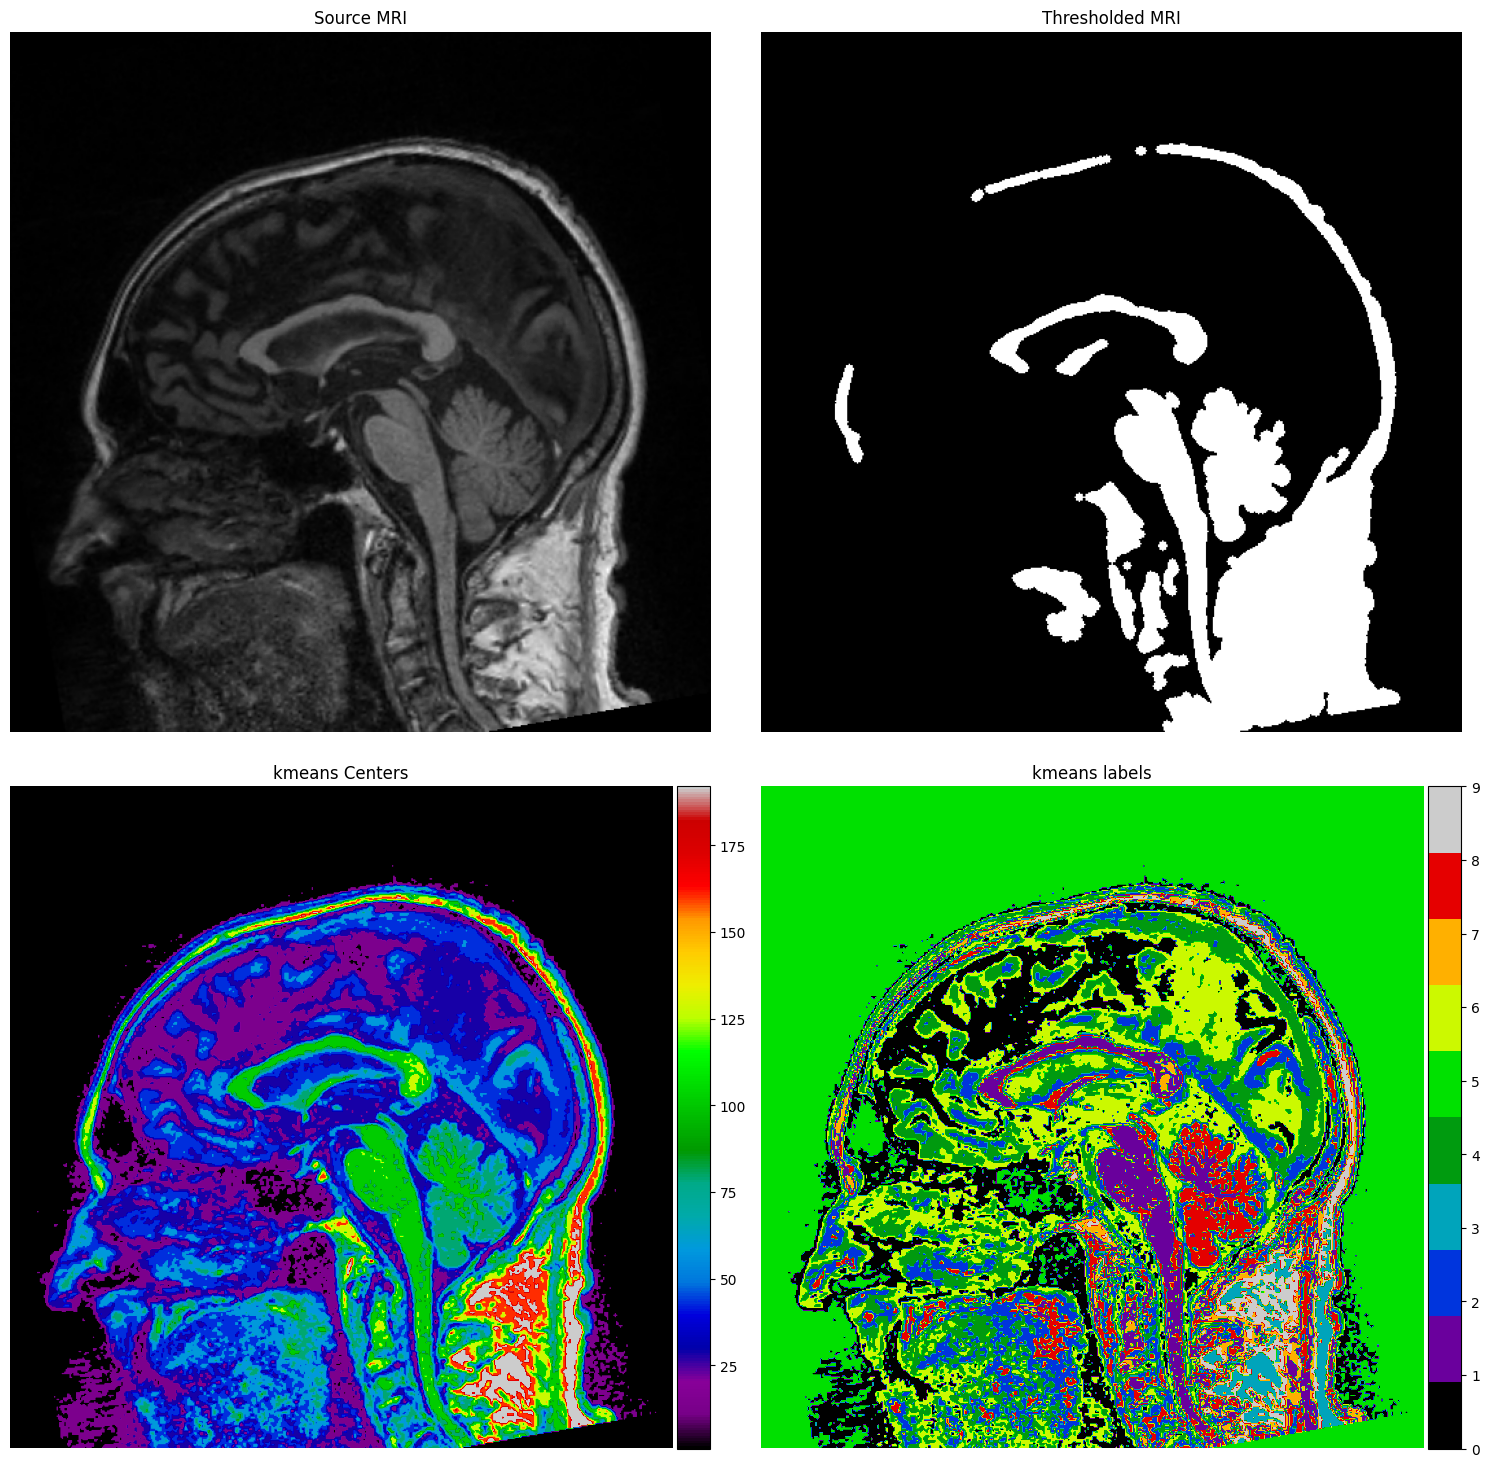

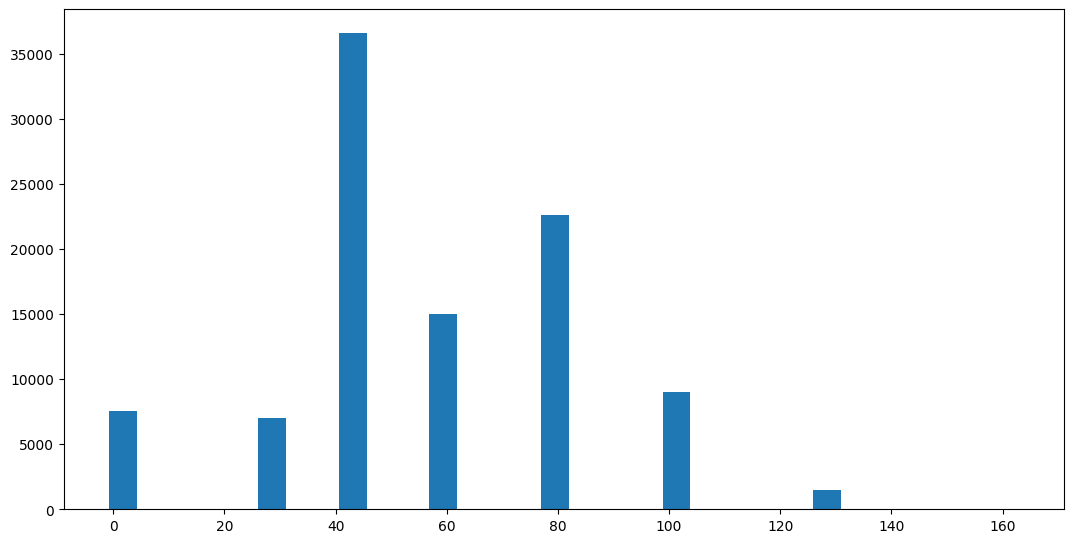

Yout Target_value =  108
Distance of your Target_value to Centers =  [ 94   7  49  84  65 106  79  21  29  52]
Your selected label (starting with 0)=  1


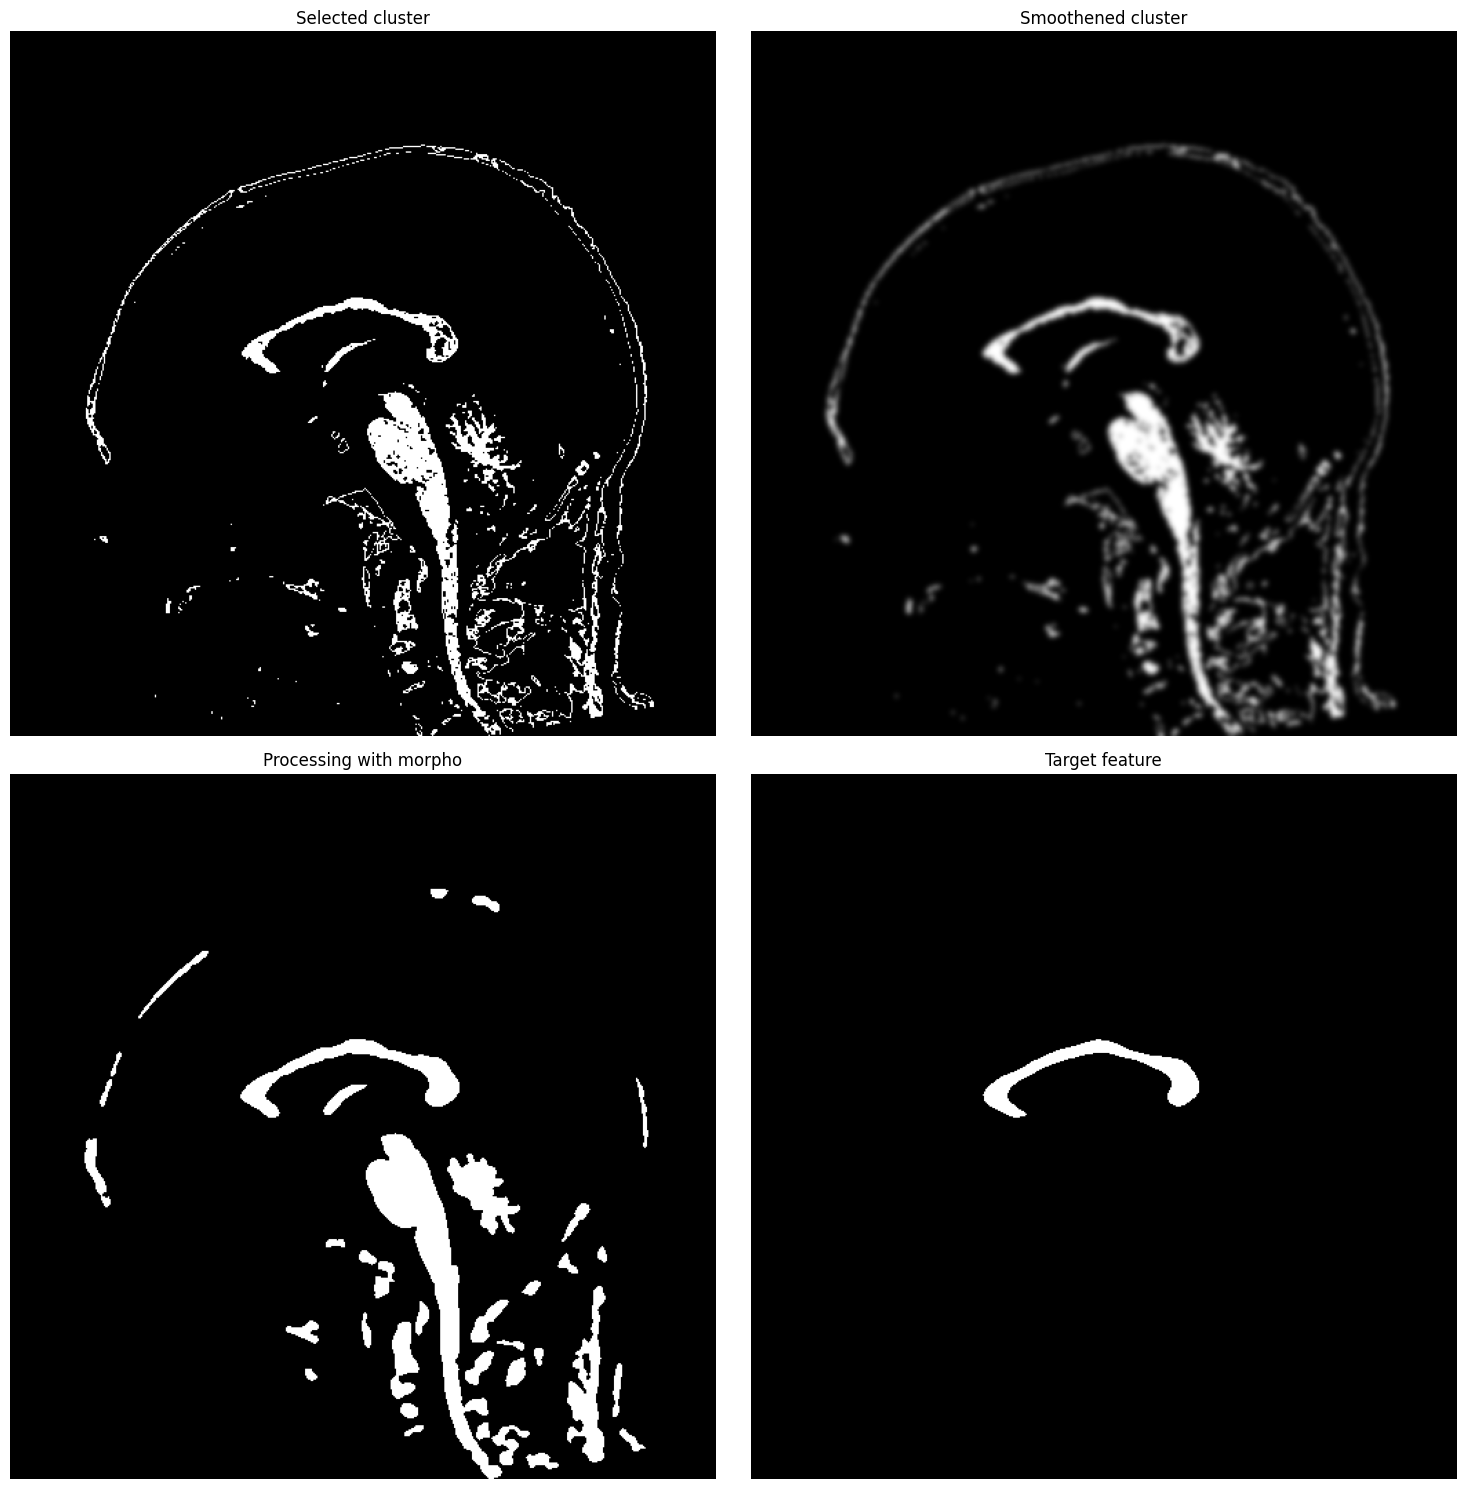

In [333]:
# APPLYING KMEANS
nber_clusters = 10
Target_value_thresh = 61.81

indexIm_test      = 0 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm_test]
Seg_brain_test = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_test = imread(filename)

# Thresholded image
Seg_thresh_test = morphology.remove_small_holes(morphology.remove_small_objects(
    Img_brain_test > Target_value_thresh, min_size=500, connectivity=1), area_threshold=500)
Seg_thresh_test = morphology.opening(Seg_thresh_test, morphology.disk(3))
Seg_thresh_test = Seg_thresh_test.astype('uint8')

# kmeans
Seg_km_test,Seg_km_labels_test = my_kmeans(Img_brain_test,nber_clusters)
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
ax = axes.ravel()

for a in ax:
    a.axis('off')

ax[0].imshow(Img_brain_test, cmap='gray')
ax[0].set_title('Source MRI')
ax[1].imshow(Seg_thresh_test, cmap='gray')
ax[1].set_title('Thresholded MRI')

tmp       = ax[2].imshow(Seg_km_test, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')

tmp     = ax[3].imshow(Seg_km_labels_test, cmap=Colormap)
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')

fig.tight_layout()
plt.show()

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels_test==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_brain_test, Img_label_mask)
    Img_label_means[i] = tmp[0]

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(),
                                         bins=Bins)

bar_width = 5
fig       = plt.figure(figsize=(10, 5))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_brain_test, Seg_thresh_test)
Target_value = Target_value[0]
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
print('Yout Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)


# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels_test==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2,
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=61.81)


fig, axes = plt.subplots(2,2, figsize=(15,15))
ax        = axes.ravel()
ax[0].set_title('Selected cluster')
ax[0].imshow(Img_label_select, cmap='gray')
ax[0].axis('off')
ax[1].set_title('Smoothened cluster')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[1].axis('off')
ax[2].set_title('Processing with morpho')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[2].axis('off')
ax[3].set_title('Target feature')
ax[3].imshow(Seg_brain_test, cmap='gray')
ax[3].axis('off')

fig.tight_layout()
plt.show()

### Streamlined Process Overview:

We've now successfully identified and prepared the correct cluster for further analysis. Our subsequent steps will involve:

1. **Element Extraction**: Isolating each individual element within our selected cluster.

2. **Feature Analysis**: Calculating key features for each element, including area, perimeter, and convexity.

3. **Optimal Match Identification**: Determining the most suitable element based on our criteria.

Initially, we'll conduct a comparison of the coordinates between the extracted elements and our reference element. Following this, for each of the remaining elements, we will calculate a score. This score is derived from a linear combination of the various feature values, each multiplied by a coefficient that reflects its relative importance.

The priority order for these features is:
- Area
- Perimeter
- Convexity

It should be noted that the method of combining these features is somewhat subjective. In my approach, I have chosen to aggregate these features through simple summation, considering that their range typically corresponds with the aforementioned priority sequence.



In [334]:
im = Img_label_select_smooth_clean.astype(int)


def extract_selectors(im):
    """
        This function computes the selectors mentioned above for a binary image.
        It first isolate each shape in a separate image
        Then, selectors are computed for each of them
    """

    comps = get_components(im)
    comp_images = components_to_images(im, comps)

    # We compute the selectors of each feature
    features = []
    for i in range(len(comp_images)):
        temp_img = comp_images[i]
        centroid = get_centroid(temp_img)
        perimeter = get_perimeter(temp_img)
        area = get_area(temp_img)
        convexity = get_convexity(temp_img)
        features.append((centroid, perimeter, area, convexity))

    return features, comp_images



def select_feature(ref_selectors, test_features):
    """
        This function returns the index of the most probable feature
        according to a reference
    """

    ref_centroid, ref_perimeter, ref_area, ref_convexity = ref_selectors[0]
    x_ref, y_ref = ref_centroid
    ref_score = ref_perimeter + ref_area + ref_convexity

    features_params = []

    # Centroids processing
    for (centroid, perimeter, area, convexity) in test_features:
        # index, (centroid, perimeter, area, convexity)
        x1, y1 = centroid
        distance2 = (x1-x_ref)**2 + (y1-y_ref)**2
        score = perimeter + area + convexity
        score_diff = abs(ref_score - score)

        features_params.append([distance2, score_diff])

    features_params = np.array(features_params)

    # First discriminate by distances
    # We only keep half of the features (assuming that their are more than one)
    selected_by_distance = np.argpartition(features_params[:,0], len(features_params) // 2)[:len(features_params) // 2]

    # Then discriminate by score
    selected = np.argmin(features_params[:,1][selected_by_distance])

    print(f'Selected feature index : {selected}')
    return selected_by_distance[selected]

### Process Testing and Results Visualization

Selected feature index : 3


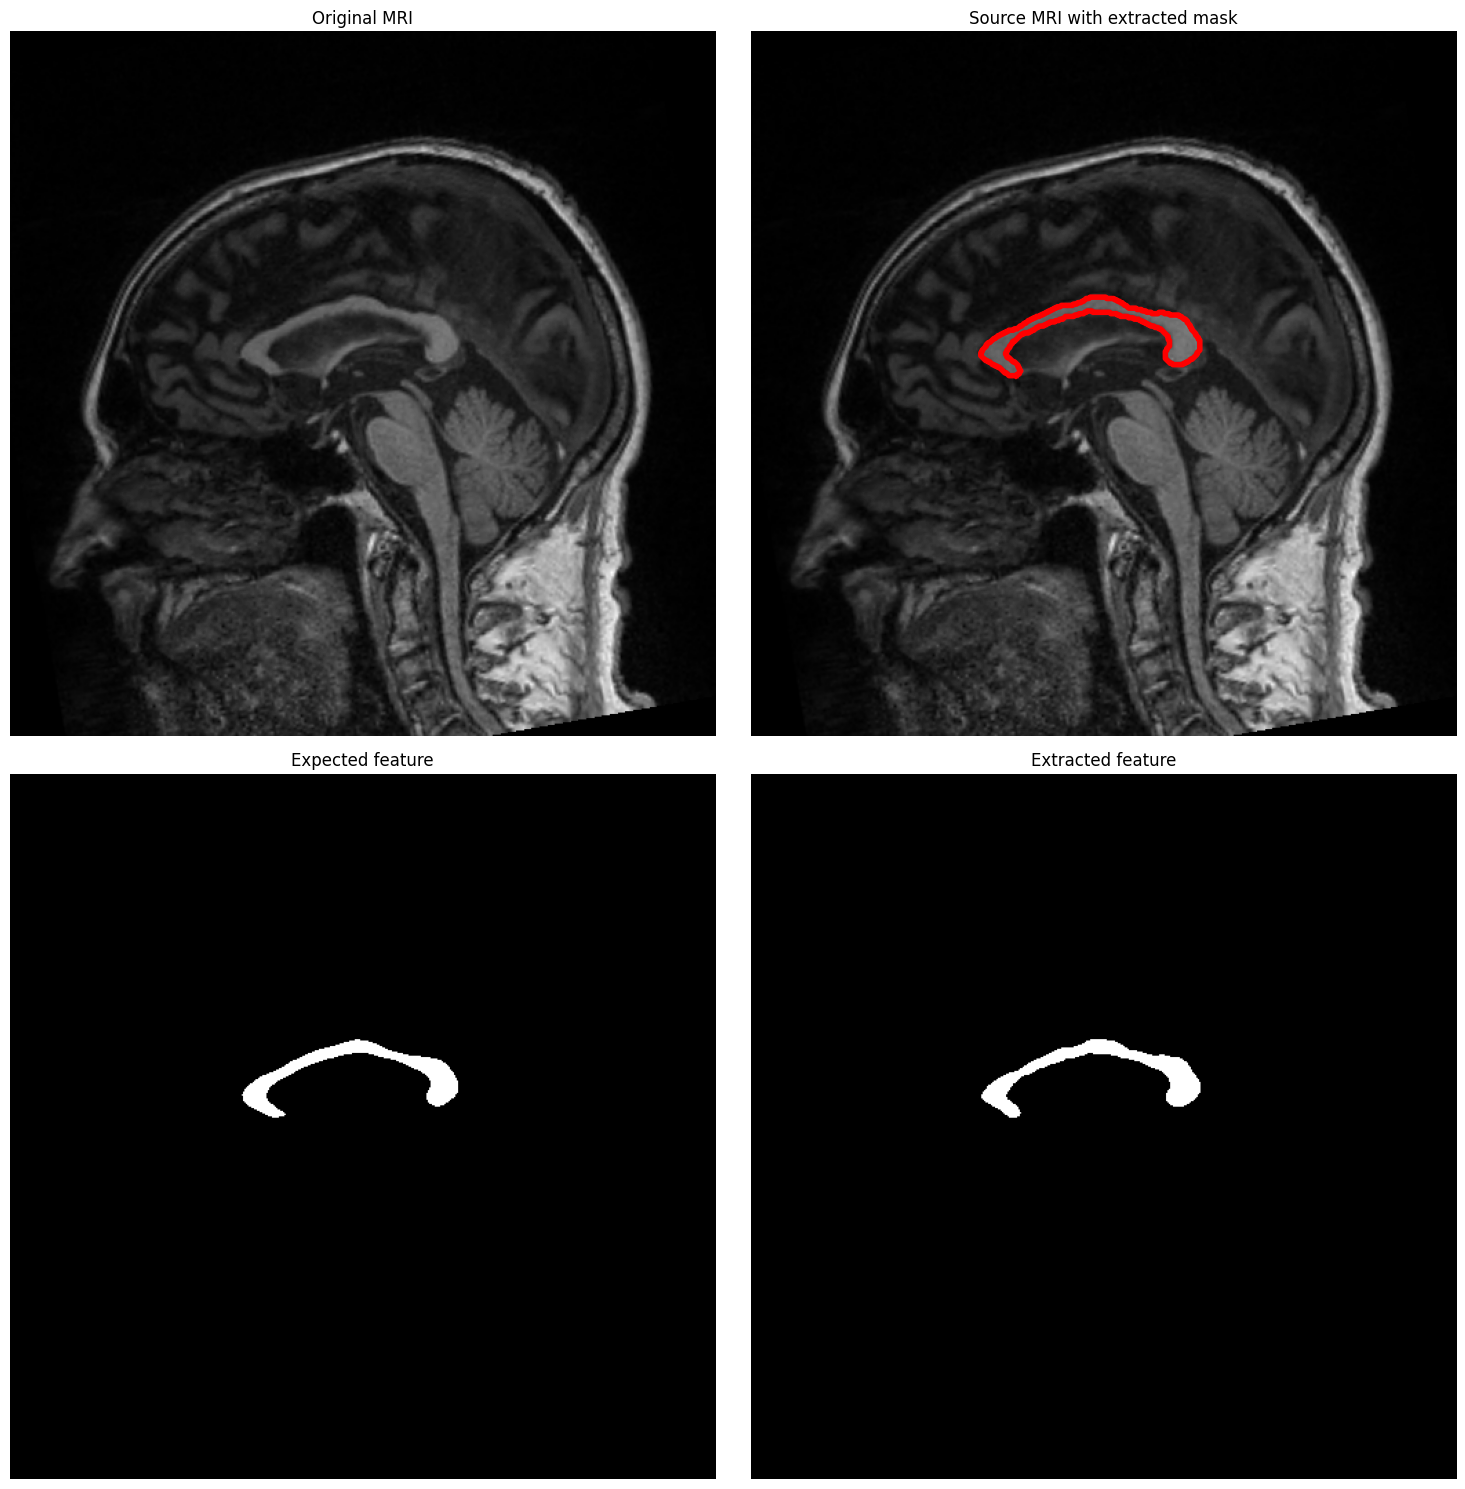

In [335]:
# =========================== TESTING ==================================
ref_feature, ref_images = extract_selectors(Seg_brain_ref.clip(max=1))
test_features, test_images = extract_selectors(im)

selected_index = select_feature(ref_feature, test_features)
selected_image = test_images[selected_index]

test_mask = find_contours(selected_image)


fig, axes = plt.subplots(2, 2, figsize=(15, 15))
ax = axes.ravel()
ax[0].set_title('Original MRI')
ax[0].imshow(Img_brain_test, cmap='gray')
ax[0].axis('off')
ax[1].set_title('Source MRI with extracted mask')
ax[1].imshow(Img_brain_test, cmap='gray')
for contour in test_mask:
    ax[1].plot(contour[:,1], contour[:,0], linewidth=4, c='r')
ax[1].axis('off')
ax[2].set_title('Expected feature')
ax[2].imshow(Seg_brain_test, cmap='gray')
ax[2].axis('off')
ax[3].set_title('Extracted feature')
ax[3].imshow(selected_image, cmap='gray')
ax[3].axis('off')
plt.tight_layout()
plt.show()

### Comprehensive Evaluation:

**Outcomes and Adaptation Strategies**:
Upon concluding our process, we observe that it has been generally successful, though not without its nuances. One notable issue is the deformation of the extracted feature, which we believe is a consequence of the K-means segmentation technique. The corpus callosum, in particular, hasn't been segmented with precision. To address this, a plausible strategy might be to experiment with increasing the number of clusters in the K-means algorithm. The hope is that by doing so, any segmentation imperfections would be segregated into clusters separate from the corpus callosum, thus enhancing the accuracy of our desired segmentation. It's worth noting that once we navigate past the initial challenges in MRI preprocessing, the rest of the process tends to unfold with a high degree of robustness.

**Key Challenges and Considerations**:
The major obstacle we encountered lies within the preprocessing stage. The methodology we utilized, which involves applying a threshold followed by K-means clustering, is markedly sensitive to variations in MRI image quality. This sensitivity manifests predominantly in the fluctuation of key parameters from one image to another. The threshold parameter, in particular, requires careful adjustment as it tends to vary significantly across different images. This variability poses a challenge, as it necessitates a tailored approach for each MRI scan, making the process less streamlined and potentially more time-consuming. Such variability underscores the need for a more adaptive or automated method of parameter selection to enhance the consistency and efficiency of the preprocessing step.
